In [2]:
!pip install tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl.metadata (3.3 kB)
  Using cached tensorflow_intel-2.18.0-cp312-cp312-win_amd64.whl.metadata (4.9 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.18.0-cp312-cp312-win_amd64.whl (7.5 kB)
Using cac

Training model 1 with {'hidden_units': [128, 64], 'activation': 'relu', 'optimizer': 'adam'}


c:\Users\97433\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training model 2 with {'hidden_units': [256, 128], 'activation': 'tanh', 'optimizer': 'sgd'}
Training model 3 with {'hidden_units': [512, 256], 'activation': 'relu', 'optimizer': 'rmsprop'}


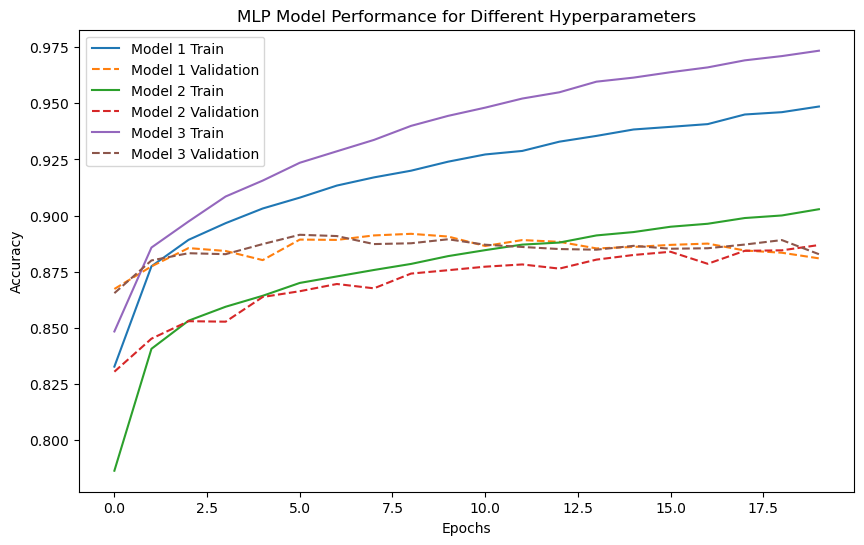

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras

# Step 1: Load Fashion MNIST dataset
fashion_mnist = fetch_openml(name="Fashion-MNIST", version=1)
X, y = fashion_mnist.data, fashion_mnist.target

# Convert labels to numerical values
y = LabelEncoder().fit_transform(y)

# Reshape images to 28x28 and filter out images with too few active pixels
X = X.values.reshape(-1, 28, 28)
valid_mask = np.sum(X > 0, axis=(1, 2)) >= 100
X = X[valid_mask]
y = y[valid_mask]

# Resize images to 14x14
X_resized = np.array([tf.image.resize(img[..., np.newaxis], (14, 14)).numpy().squeeze() for img in X])
X_resized = X_resized.reshape(X_resized.shape[0], -1)

# Normalize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resized)

# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Step 3: Implement a Multilayer Perceptron with hyperparameter tuning

def build_mlp_model(input_dim, num_classes, hidden_units, activation, optimizer):
    model = keras.Sequential([
        keras.layers.Dense(hidden_units[0], activation=activation, input_shape=(input_dim,)),
        keras.layers.Dense(hidden_units[1], activation=activation),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define hyperparameters
hyperparams = [
    {'hidden_units': [128, 64], 'activation': 'relu', 'optimizer': 'adam'},
    {'hidden_units': [256, 128], 'activation': 'tanh', 'optimizer': 'sgd'},
    {'hidden_units': [512, 256], 'activation': 'relu', 'optimizer': 'rmsprop'}
]

# Train and evaluate models
histories = {}
for i, params in enumerate(hyperparams):
    print(f"Training model {i+1} with {params}")
    model = build_mlp_model(100, len(np.unique(y)), params['hidden_units'], params['activation'], params['optimizer'])
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    histories[f"Model {i+1}"] = history.history

# Plot training history
plt.figure(figsize=(10, 6))
for i, (key, hist) in enumerate(histories.items()):
    plt.plot(hist['accuracy'], label=f'{key} Train')
    plt.plot(hist['val_accuracy'], label=f'{key} Validation', linestyle='dashed')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('MLP Model Performance for Different Hyperparameters')
plt.show()
